# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


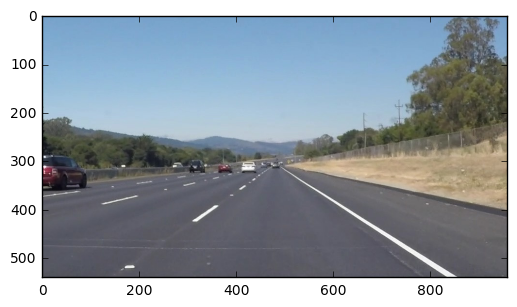

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    c=0
    count=0
    avgm=0
    leftline=[]
    rightline=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:                                  
            #print('line is',line)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if x1!=x2:
                count=count+1                
                m=(y2-y1)/(x2-x1)
                avgm=(m+(count-1)*avgm)/count
                if m<=0:
                    leftline.extend(line)
                else:
                    rightline.extend(line)
            
                
    
    
    
    lmean=np.mean(leftline, axis=0)
    rmean=np.mean(rightline, axis=0)
    means=[lmean,rmean]
    """
    print('---------------------------------left line-------------------------------------')
    print('left line is',leftline)
    print('---------------------------------right line-------------------------------------')
    print('right line is',rightline)
    print('---------------------------------mean-------------------------------------')    
    print('left line mean is',lmean)
    print('right line mean is',rmean)
    print('mean is',means)
    """
    
    
    return means
            

def hough_lines(image_fordetecting_lines,image_for_drawing, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    lines = cv2.HoughLinesP(image_fordetecting_lines, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*image_fordetecting_lines.shape, 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    temp_img=np.copy(image_for_drawing)    
    mean=draw_lines(temp_img, lines)       
    mean=np.around(mean)
    mean=np.int32(mean)
    
    
    
    
    
    plt.figure(1)    
    plt.imshow(image_for_drawing, cmap='gray')
    
    plt.figure(2)
    plt.imshow(temp_img, cmap='gray')    
    print('____________________________________________________________________')
    print('lines===========',lines)
    print('mean============',mean)
    print('type of line',type(lines))
    print('shape of line',lines.shape)
    print('type of line',lines.dtype)
    print('type of mean',type(mean))
    print('shape of mean',mean.shape)
    print('type of mean',mean.dtype)
    
    
    
    igno=draw_lines(image_for_drawing, [mean])
    
    plt.figure(3)    
    plt.imshow(image_for_drawing, cmap='gray')  
    
    plt.figure(3)
    plt.imshow(image_for_drawing, cmap='gray')
    
    #return line_img
    #return image_for_drawing
    return mean

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)   




## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

run your solution on all test_images and make copies into the test_images directory).

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


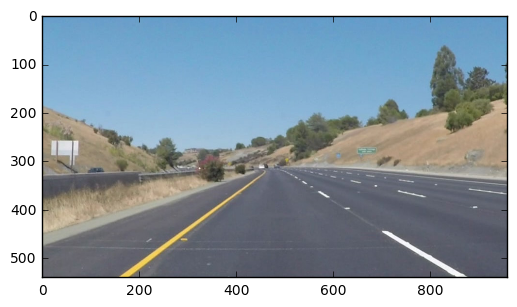

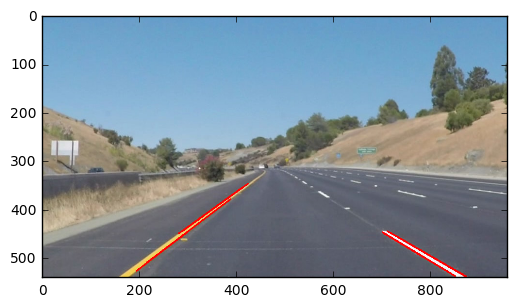

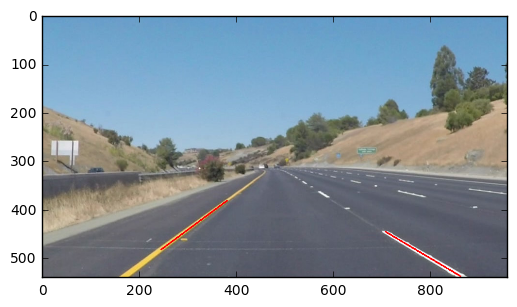

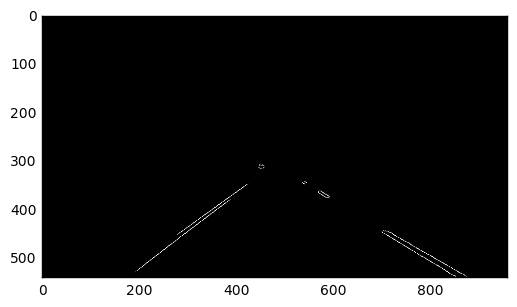

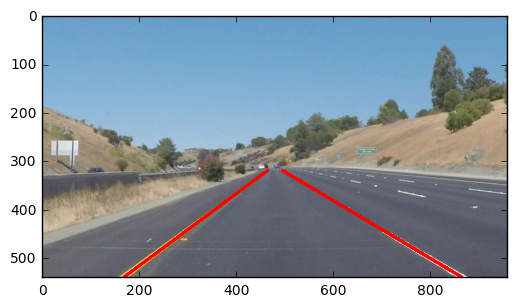

In [6]:
import os
images=os.listdir("test_images/")

image=images[3]
a='test_images/'+image
img = mpimg.imread(a)
colorimage=img
i=0
"""
print('This is',image, 'with dimesions:', img.shape)   
plt.figure(1)
plt.imshow(img)
"""

#print('The gray scale version is')
img=grayscale(img)
"""
plt.figure(2)
plt.imshow(img, cmap='gray')
"""
print('The gaussian blurred version is')
img=gaussian_blur(img,5)

img=gaussian_blur(img,5)
img=gaussian_blur(img,5)
img=gaussian_blur(img,5)
i=i+1
plt.figure(i)
plt.imshow(img, cmap='gray')


print('The canny version is')
img=canny(img,120,150)
i=i+1
plt.figure(i)
plt.imshow(img, cmap='gray')

left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475,320]

x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
ver=np.array([[200,img.shape[0]],[500,200],[img.shape[1],img.shape[0]]])
#print(type(ver))


####################################
print('The masked region is')
vers=[[(180,img.shape[0],450,300)],[(450,300,540,300)],[(540,300,img.shape[1],img.shape[0])]]
vers=[[(100,img.shape[0],450,320)],[(450,320,540,320)],[(540,320,img.shape[1],img.shape[0])]]

#draw_lines(img, vers)

i=i+1
plt.figure(i)
plt.imshow(img, cmap='gray')

print('The masked image region is')


vers=np.array([[180,img.shape[0]],[450,300],[540,300],[img.shape[1],img.shape[0]]])

points = np.array([[910, 641], [206, 632], [696, 488], [458, 485]])



#img=region_of_interest(img, np.int32([vers]))
img=region_of_interest(img, np.int32([vers]))
i=i+1
plt.figure(i)
plt.imshow(img, cmap='gray')


##########################################################################################################################





print('Hough transform on masked region is')
vers=[[(180,img.shape[0],450,300)],[(450,300,540,300)],[(540,300,img.shape[1],img.shape[0])]]

hough_image=hough_lines(img,colorimage, 1, np.pi/180, 50, 40, 100)





##########################################################################################################################



lx1=hough_image.item(0,0)
ly1=hough_image.item(0,1)

lx2=hough_image.item(0,2)
ly2=hough_image.item(0,3)


rx1=hough_image.item(1,0)
ry1=hough_image.item(1,1)

rx2=hough_image.item(1,2)
ry2=hough_image.item(1,3)
print(lx1,lx2,rx1,rx2)
m1=(ly2-ly1)/(lx2-lx1)
m2=(ry2-ry1)/(rx2-rx1)

x1=lx1+ ((540-ly1)/(m1))
x2=lx1+ ((320-ly1)/(m1))

x3=rx1+ ((320-ry1)/(m2))
x4=rx1+ ((540-ry1)/(m2))

print(x1)
print(x2)
print(x3)
print(x4)


 
pointsfound=[[[x1 ,540,x2,320],[x3,320,x4,540]]]
pointsfound=np.around(pointsfound)
pointsfound=np.int32(pointsfound)



draw_lines(colorimage,pointsfound,color=[255, 0, 0], thickness=5)
 
i=i+1
plt.figure(i)
plt.imshow(colorimage)








## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    image=images[3]
    a='test_images/'+image
    img = mpimg.imread(a)
    colorimage=img
    i=0
    """
    print('This is',image, 'with dimesions:', img.shape)   
    plt.figure(1)
    plt.imshow(img)
    """

    #print('The gray scale version is')
    img=grayscale(img)
    """
    plt.figure(2)
    plt.imshow(img, cmap='gray')
    """
    print('The gaussian blurred version is')
    img=gaussian_blur(img,5)

    img=gaussian_blur(img,5)
    img=gaussian_blur(img,5)
    img=gaussian_blur(img,5)
    i=i+1
    plt.figure(i)
    plt.imshow(img, cmap='gray')


    print('The canny version is')
    img=canny(img,120,150)
    i=i+1
    plt.figure(i)
    plt.imshow(img, cmap='gray')

    left_bottom = [0, 539]
    right_bottom = [900, 539]
    apex = [475,320]

    x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
    ver=np.array([[200,img.shape[0]],[500,200],[img.shape[1],img.shape[0]]])
    #print(type(ver))


    ####################################
    print('The masked region is')
    vers=[[(180,img.shape[0],450,300)],[(450,300,540,300)],[(540,300,img.shape[1],img.shape[0])]]
    vers=[[(100,img.shape[0],450,320)],[(450,320,540,320)],[(540,320,img.shape[1],img.shape[0])]]

    #draw_lines(img, vers)

    i=i+1
    plt.figure(i)
    plt.imshow(img, cmap='gray')

    print('The masked image region is')


    vers=np.array([[180,img.shape[0]],[450,300],[540,300],[img.shape[1],img.shape[0]]])

    points = np.array([[910, 641], [206, 632], [696, 488], [458, 485]])



    #img=region_of_interest(img, np.int32([vers]))
    img=region_of_interest(img, np.int32([vers]))
    i=i+1
    plt.figure(i)
    plt.imshow(img, cmap='gray')
    

    ##########################################################################################################################





    print('Hough transform on masked region is')
    vers=[[(180,img.shape[0],450,300)],[(450,300,540,300)],[(540,300,img.shape[1],img.shape[0])]]

    hough_image=hough_lines(img,colorimage, 1, np.pi/180, 50, 40, 100)





    ##########################################################################################################################



    lx1=hough_image.item(0,0)
    ly1=hough_image.item(0,1)

    lx2=hough_image.item(0,2)
    ly2=hough_image.item(0,3)


    rx1=hough_image.item(1,0)
    ry1=hough_image.item(1,1)

    rx2=hough_image.item(1,2)
    ry2=hough_image.item(1,3)
    print(lx1,lx2,rx1,rx2)
    m1=(ly2-ly1)/(lx2-lx1)
    m2=(ry2-ry1)/(rx2-rx1)

    x1=lx1+ ((540-ly1)/(m1))
    x2=lx1+ ((320-ly1)/(m1))

    x3=rx1+ ((320-ry1)/(m2))
    x4=rx1+ ((540-ry1)/(m2))

    print(x1)
    print(x2)
    print(x3)
    print(x4)


 
    pointsfound=[[[x1 ,540,x2,320],[x3,320,x4,540]]]
    pointsfound=np.around(pointsfound)
    pointsfound=np.int32(pointsfound)



    draw_lines(colorimage,pointsfound,color=[255, 0, 0], thickness=5)
 
    i=i+1
    plt.figure(i)
    plt.imshow(colorimage)

    
    

    return colorimage

Let's try the one with the solid white lane on the right first ...

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  0%|▎                                                                                 | 1/222 [00:00<02:29,  1.48it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  1%|▋                                                                                 | 2/222 [00:00<02:05,  1.76it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  1%|█                                                                                 | 3/222 [00:01<01:48,  2.01it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  2%|█▍                                                                                | 4/222 [00:01<01:34,  2.32it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  2%|█▊                                                                                | 5/222 [00:01<01:20,  2.69it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  3%|██▏                                                                               | 6/222 [00:02<01:12,  2.98it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  3%|██▌                                                                               | 7/222 [00:02<01:10,  3.03it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  4%|██▉                                                                               | 8/222 [00:02<01:11,  2.98it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  4%|███▎                                                                              | 9/222 [00:03<01:11,  2.98it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  5%|███▋                                                                             | 10/222 [00:03<01:07,  3.13it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  5%|████                                                                             | 11/222 [00:03<01:02,  3.35it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  5%|████▍                                                                            | 12/222 [00:03<00:59,  3.51it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  6%|████▋                                                                            | 13/222 [00:04<00:58,  3.59it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  6%|█████                                                                            | 14/222 [00:04<00:57,  3.63it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  7%|█████▍                                                                           | 15/222 [00:04<01:00,  3.44it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  7%|█████▊                                                                           | 16/222 [00:05<01:04,  3.21it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  8%|██████▏                                                                          | 17/222 [00:05<01:02,  3.30it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  8%|██████▌                                                                          | 18/222 [00:05<01:00,  3.40it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  9%|██████▉                                                                          | 19/222 [00:05<01:00,  3.37it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  9%|███████▎                                                                         | 20/222 [00:06<00:58,  3.43it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


  9%|███████▋                                                                         | 21/222 [00:06<00:59,  3.39it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 10%|████████                                                                         | 22/222 [00:06<00:56,  3.57it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 10%|████████▍                                                                        | 23/222 [00:07<00:54,  3.66it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 11%|████████▊                                                                        | 24/222 [00:07<00:58,  3.38it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 11%|█████████                                                                        | 25/222 [00:07<00:57,  3.43it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 12%|█████████▍                                                                       | 26/222 [00:07<00:54,  3.61it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 12%|█████████▊                                                                       | 27/222 [00:08<00:52,  3.68it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 13%|██████████▏                                                                      | 28/222 [00:08<00:52,  3.72it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 13%|██████████▌                                                                      | 29/222 [00:08<00:52,  3.64it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 14%|██████████▉                                                                      | 30/222 [00:09<00:53,  3.58it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 14%|███████████▎                                                                     | 31/222 [00:09<00:57,  3.30it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 14%|███████████▋                                                                     | 32/222 [00:09<00:59,  3.17it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 15%|████████████                                                                     | 33/222 [00:10<00:58,  3.25it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 15%|████████████▍                                                                    | 34/222 [00:10<00:55,  3.38it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 16%|████████████▊                                                                    | 35/222 [00:10<00:54,  3.45it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 16%|█████████████▏                                                                   | 36/222 [00:10<00:51,  3.62it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 17%|█████████████▌                                                                   | 37/222 [00:11<00:48,  3.79it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 17%|█████████████▊                                                                   | 38/222 [00:11<00:49,  3.74it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 18%|██████████████▏                                                                  | 39/222 [00:11<00:46,  3.89it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 18%|██████████████▌                                                                  | 40/222 [00:11<00:45,  4.01it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 18%|██████████████▉                                                                  | 41/222 [00:12<00:47,  3.84it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 19%|███████████████▎                                                                 | 42/222 [00:12<00:46,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 19%|███████████████▋                                                                 | 43/222 [00:12<00:45,  3.97it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 20%|████████████████                                                                 | 44/222 [00:12<00:44,  4.03it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 20%|████████████████▍                                                                | 45/222 [00:13<00:45,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 21%|████████████████▊                                                                | 46/222 [00:13<00:45,  3.86it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 21%|█████████████████▏                                                               | 47/222 [00:13<00:48,  3.64it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 22%|█████████████████▌                                                               | 48/222 [00:13<00:47,  3.67it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 22%|█████████████████▉                                                               | 49/222 [00:14<00:48,  3.54it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 23%|██████████████████▏                                                              | 50/222 [00:14<00:50,  3.42it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 23%|██████████████████▌                                                              | 51/222 [00:14<00:48,  3.49it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 23%|██████████████████▉                                                              | 52/222 [00:15<00:51,  3.30it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 24%|███████████████████▎                                                             | 53/222 [00:15<00:52,  3.21it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 24%|███████████████████▋                                                             | 54/222 [00:15<00:49,  3.38it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 25%|████████████████████                                                             | 55/222 [00:15<00:46,  3.58it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 25%|████████████████████▍                                                            | 56/222 [00:16<00:45,  3.68it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 26%|████████████████████▊                                                            | 57/222 [00:16<00:48,  3.42it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 26%|█████████████████████▏                                                           | 58/222 [00:16<00:43,  3.78it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 27%|█████████████████████▌                                                           | 59/222 [00:17<00:43,  3.75it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 27%|█████████████████████▉                                                           | 60/222 [00:17<00:43,  3.72it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 27%|██████████████████████▎                                                          | 61/222 [00:17<00:41,  3.89it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 28%|██████████████████████▌                                                          | 62/222 [00:17<00:39,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 28%|██████████████████████▉                                                          | 63/222 [00:17<00:37,  4.20it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 29%|███████████████████████▎                                                         | 64/222 [00:18<00:37,  4.19it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 29%|███████████████████████▋                                                         | 65/222 [00:18<00:39,  3.97it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 30%|████████████████████████                                                         | 66/222 [00:18<00:38,  4.02it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 30%|████████████████████████▍                                                        | 67/222 [00:18<00:37,  4.14it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 31%|████████████████████████▊                                                        | 68/222 [00:19<00:40,  3.78it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 31%|█████████████████████████▏                                                       | 69/222 [00:19<00:38,  3.95it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 32%|█████████████████████████▌                                                       | 70/222 [00:19<00:37,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 32%|█████████████████████████▉                                                       | 71/222 [00:19<00:36,  4.17it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 32%|██████████████████████████▎                                                      | 72/222 [00:20<00:36,  4.06it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 33%|██████████████████████████▋                                                      | 73/222 [00:20<00:36,  4.04it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 33%|███████████████████████████                                                      | 74/222 [00:20<00:37,  3.99it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 34%|███████████████████████████▎                                                     | 75/222 [00:20<00:36,  4.04it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 34%|███████████████████████████▋                                                     | 76/222 [00:21<00:36,  4.03it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 35%|████████████████████████████                                                     | 77/222 [00:21<00:39,  3.68it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 35%|████████████████████████████▍                                                    | 78/222 [00:21<00:38,  3.72it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 36%|████████████████████████████▊                                                    | 79/222 [00:22<00:37,  3.78it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 36%|█████████████████████████████▏                                                   | 80/222 [00:22<00:35,  4.04it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 36%|█████████████████████████████▌                                                   | 81/222 [00:22<00:34,  4.08it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 37%|█████████████████████████████▉                                                   | 82/222 [00:22<00:33,  4.18it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 37%|██████████████████████████████▎                                                  | 83/222 [00:22<00:32,  4.28it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 38%|██████████████████████████████▋                                                  | 84/222 [00:23<00:30,  4.47it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 38%|███████████████████████████████                                                  | 85/222 [00:23<00:29,  4.61it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 39%|███████████████████████████████▍                                                 | 86/222 [00:23<00:31,  4.38it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 39%|███████████████████████████████▋                                                 | 87/222 [00:23<00:32,  4.20it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 40%|████████████████████████████████                                                 | 88/222 [00:24<00:32,  4.18it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 40%|████████████████████████████████▍                                                | 89/222 [00:24<00:32,  4.11it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 41%|████████████████████████████████▊                                                | 90/222 [00:24<00:31,  4.16it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 41%|█████████████████████████████████▏                                               | 91/222 [00:24<00:30,  4.27it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 41%|█████████████████████████████████▌                                               | 92/222 [00:25<00:30,  4.30it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 42%|█████████████████████████████████▉                                               | 93/222 [00:25<00:31,  4.14it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 42%|██████████████████████████████████▎                                              | 94/222 [00:25<00:32,  4.00it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 43%|██████████████████████████████████▋                                              | 95/222 [00:25<00:31,  4.03it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 43%|███████████████████████████████████                                              | 96/222 [00:26<00:32,  3.86it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 44%|███████████████████████████████████▍                                             | 97/222 [00:26<00:34,  3.67it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 44%|███████████████████████████████████▊                                             | 98/222 [00:26<00:32,  3.80it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 45%|████████████████████████████████████                                             | 99/222 [00:26<00:30,  3.98it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 45%|████████████████████████████████████                                            | 100/222 [00:27<00:31,  3.88it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 45%|████████████████████████████████████▍                                           | 101/222 [00:27<00:35,  3.44it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 46%|████████████████████████████████████▊                                           | 102/222 [00:27<00:34,  3.47it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 46%|█████████████████████████████████████                                           | 103/222 [00:28<00:33,  3.54it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 47%|█████████████████████████████████████▍                                          | 104/222 [00:28<00:32,  3.59it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 47%|█████████████████████████████████████▊                                          | 105/222 [00:28<00:31,  3.66it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 48%|██████████████████████████████████████▏                                         | 106/222 [00:28<00:31,  3.68it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 48%|██████████████████████████████████████▌                                         | 107/222 [00:29<00:30,  3.79it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 49%|██████████████████████████████████████▉                                         | 108/222 [00:29<00:31,  3.66it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 49%|███████████████████████████████████████▎                                        | 109/222 [00:29<00:30,  3.74it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 50%|███████████████████████████████████████▋                                        | 110/222 [00:29<00:29,  3.82it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 50%|████████████████████████████████████████                                        | 111/222 [00:30<00:28,  3.86it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 50%|████████████████████████████████████████▎                                       | 112/222 [00:30<00:28,  3.84it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 51%|████████████████████████████████████████▋                                       | 113/222 [00:30<00:30,  3.54it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 51%|█████████████████████████████████████████                                       | 114/222 [00:31<00:32,  3.30it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 52%|█████████████████████████████████████████▍                                      | 115/222 [00:31<00:31,  3.40it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 52%|█████████████████████████████████████████▊                                      | 116/222 [00:31<00:30,  3.53it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 53%|██████████████████████████████████████████▏                                     | 117/222 [00:31<00:28,  3.65it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 53%|██████████████████████████████████████████▌                                     | 118/222 [00:32<00:27,  3.78it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 54%|██████████████████████████████████████████▉                                     | 119/222 [00:32<00:26,  3.95it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 54%|███████████████████████████████████████████▏                                    | 120/222 [00:32<00:25,  3.98it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 55%|███████████████████████████████████████████▌                                    | 121/222 [00:32<00:24,  4.04it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 55%|███████████████████████████████████████████▉                                    | 122/222 [00:33<00:24,  4.11it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 55%|████████████████████████████████████████████▎                                   | 123/222 [00:33<00:24,  4.04it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 56%|████████████████████████████████████████████▋                                   | 124/222 [00:33<00:24,  4.05it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 56%|█████████████████████████████████████████████                                   | 125/222 [00:33<00:23,  4.15it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:34<00:22,  4.22it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 57%|█████████████████████████████████████████████▊                                  | 127/222 [00:34<00:23,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 58%|██████████████████████████████████████████████▏                                 | 128/222 [00:34<00:24,  3.80it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 58%|██████████████████████████████████████████████▍                                 | 129/222 [00:34<00:24,  3.83it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:35<00:23,  3.85it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 59%|███████████████████████████████████████████████▏                                | 131/222 [00:35<00:24,  3.78it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 59%|███████████████████████████████████████████████▌                                | 132/222 [00:35<00:24,  3.61it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 60%|███████████████████████████████████████████████▉                                | 133/222 [00:36<00:26,  3.34it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 60%|████████████████████████████████████████████████▎                               | 134/222 [00:36<00:26,  3.36it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 61%|████████████████████████████████████████████████▋                               | 135/222 [00:36<00:24,  3.49it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 61%|█████████████████████████████████████████████████                               | 136/222 [00:36<00:23,  3.72it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 62%|█████████████████████████████████████████████████▎                              | 137/222 [00:37<00:22,  3.78it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 62%|█████████████████████████████████████████████████▋                              | 138/222 [00:37<00:22,  3.70it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 63%|██████████████████████████████████████████████████                              | 139/222 [00:37<00:22,  3.68it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 63%|██████████████████████████████████████████████████▍                             | 140/222 [00:37<00:20,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 64%|██████████████████████████████████████████████████▊                             | 141/222 [00:38<00:19,  4.08it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:38<00:20,  3.88it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 64%|███████████████████████████████████████████████████▌                            | 143/222 [00:38<00:20,  3.86it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 65%|███████████████████████████████████████████████████▉                            | 144/222 [00:38<00:19,  3.94it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 65%|████████████████████████████████████████████████████▎                           | 145/222 [00:39<00:19,  4.01it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:39<00:20,  3.66it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 66%|████████████████████████████████████████████████████▉                           | 147/222 [00:39<00:21,  3.51it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 67%|█████████████████████████████████████████████████████▎                          | 148/222 [00:40<00:20,  3.70it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 67%|█████████████████████████████████████████████████████▋                          | 149/222 [00:40<00:20,  3.59it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 68%|██████████████████████████████████████████████████████                          | 150/222 [00:40<00:20,  3.54it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 68%|██████████████████████████████████████████████████████▍                         | 151/222 [00:40<00:19,  3.55it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 68%|██████████████████████████████████████████████████████▊                         | 152/222 [00:41<00:19,  3.64it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 69%|███████████████████████████████████████████████████████▏                        | 153/222 [00:41<00:18,  3.71it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 69%|███████████████████████████████████████████████████████▍                        | 154/222 [00:41<00:17,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 70%|███████████████████████████████████████████████████████▊                        | 155/222 [00:41<00:16,  3.95it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 70%|████████████████████████████████████████████████████████▏                       | 156/222 [00:42<00:16,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 71%|████████████████████████████████████████████████████████▌                       | 157/222 [00:42<00:16,  4.05it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:42<00:15,  4.08it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 72%|█████████████████████████████████████████████████████████▎                      | 159/222 [00:42<00:15,  3.97it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 72%|█████████████████████████████████████████████████████████▋                      | 160/222 [00:43<00:15,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:43<00:16,  3.79it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 73%|██████████████████████████████████████████████████████████▍                     | 162/222 [00:43<00:15,  3.84it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 73%|██████████████████████████████████████████████████████████▋                     | 163/222 [00:43<00:14,  4.05it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 74%|███████████████████████████████████████████████████████████                     | 164/222 [00:44<00:14,  4.05it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 74%|███████████████████████████████████████████████████████████▍                    | 165/222 [00:44<00:14,  4.01it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 75%|███████████████████████████████████████████████████████████▊                    | 166/222 [00:44<00:13,  4.08it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 75%|████████████████████████████████████████████████████████████▏                   | 167/222 [00:44<00:13,  4.01it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 76%|████████████████████████████████████████████████████████████▌                   | 168/222 [00:45<00:13,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 76%|████████████████████████████████████████████████████████████▉                   | 169/222 [00:45<00:13,  3.83it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 77%|█████████████████████████████████████████████████████████████▎                  | 170/222 [00:45<00:13,  3.97it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 77%|█████████████████████████████████████████████████████████████▌                  | 171/222 [00:45<00:13,  3.88it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 77%|█████████████████████████████████████████████████████████████▉                  | 172/222 [00:46<00:12,  3.98it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 78%|██████████████████████████████████████████████████████████████▎                 | 173/222 [00:46<00:12,  3.92it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 78%|██████████████████████████████████████████████████████████████▋                 | 174/222 [00:46<00:13,  3.57it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 79%|███████████████████████████████████████████████████████████████                 | 175/222 [00:46<00:12,  3.81it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 79%|███████████████████████████████████████████████████████████████▍                | 176/222 [00:47<00:11,  3.86it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 80%|███████████████████████████████████████████████████████████████▊                | 177/222 [00:47<00:11,  4.05it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:47<00:10,  4.16it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 81%|████████████████████████████████████████████████████████████████▌               | 179/222 [00:47<00:09,  4.34it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 81%|████████████████████████████████████████████████████████████████▊               | 180/222 [00:48<00:09,  4.27it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 82%|█████████████████████████████████████████████████████████████████▏              | 181/222 [00:48<00:10,  3.99it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:48<00:09,  4.02it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 82%|█████████████████████████████████████████████████████████████████▉              | 183/222 [00:48<00:09,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 83%|██████████████████████████████████████████████████████████████████▎             | 184/222 [00:49<00:09,  4.17it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:49<00:08,  4.13it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 84%|███████████████████████████████████████████████████████████████████             | 186/222 [00:49<00:08,  4.09it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 84%|███████████████████████████████████████████████████████████████████▍            | 187/222 [00:49<00:08,  3.96it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:50<00:08,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 85%|████████████████████████████████████████████████████████████████████            | 189/222 [00:50<00:08,  3.79it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:50<00:08,  3.67it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 86%|████████████████████████████████████████████████████████████████████▊           | 191/222 [00:50<00:08,  3.70it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 86%|█████████████████████████████████████████████████████████████████████▏          | 192/222 [00:51<00:07,  3.84it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 87%|█████████████████████████████████████████████████████████████████████▌          | 193/222 [00:51<00:08,  3.36it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:51<00:07,  3.53it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 88%|██████████████████████████████████████████████████████████████████████▎         | 195/222 [00:52<00:07,  3.74it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 88%|██████████████████████████████████████████████████████████████████████▋         | 196/222 [00:52<00:07,  3.71it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 89%|██████████████████████████████████████████████████████████████████████▉         | 197/222 [00:52<00:06,  3.82it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 89%|███████████████████████████████████████████████████████████████████████▎        | 198/222 [00:52<00:06,  3.97it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 90%|███████████████████████████████████████████████████████████████████████▋        | 199/222 [00:53<00:05,  4.08it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 90%|████████████████████████████████████████████████████████████████████████        | 200/222 [00:53<00:05,  3.91it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 91%|████████████████████████████████████████████████████████████████████████▍       | 201/222 [00:53<00:05,  3.90it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 91%|████████████████████████████████████████████████████████████████████████▊       | 202/222 [00:53<00:05,  3.99it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:54<00:04,  4.15it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 92%|█████████████████████████████████████████████████████████████████████████▌      | 204/222 [00:54<00:04,  3.83it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 92%|█████████████████████████████████████████████████████████████████████████▊      | 205/222 [00:54<00:04,  3.71it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:54<00:04,  3.81it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 93%|██████████████████████████████████████████████████████████████████████████▌     | 207/222 [00:55<00:03,  3.92it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 94%|██████████████████████████████████████████████████████████████████████████▉     | 208/222 [00:55<00:03,  3.70it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 94%|███████████████████████████████████████████████████████████████████████████▎    | 209/222 [00:55<00:03,  3.79it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 95%|███████████████████████████████████████████████████████████████████████████▋    | 210/222 [00:55<00:03,  3.83it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 95%|████████████████████████████████████████████████████████████████████████████    | 211/222 [00:56<00:02,  3.96it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 95%|████████████████████████████████████████████████████████████████████████████▍   | 212/222 [00:56<00:02,  4.00it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 96%|████████████████████████████████████████████████████████████████████████████▊   | 213/222 [00:56<00:02,  4.14it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 96%|█████████████████████████████████████████████████████████████████████████████   | 214/222 [00:56<00:01,  4.08it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:57<00:01,  3.99it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 216/222 [00:57<00:01,  3.81it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 217/222 [00:57<00:01,  3.85it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:57<00:00,  4.00it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 219/222 [00:58<00:00,  4.11it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


 99%|███████████████████████████████████████████████████████████████████████████████▎| 220/222 [00:58<00:00,  4.24it/s]

The gaussian blurred version is
The canny version is
The masked region is
The masked image region is
Hough transform on masked region is
____________________________________________________________________
lines=========== [[[701 448 851 538]]

 [[714 446 874 538]]

 [[215 510 388 379]]

 [[281 450 412 355]]

 [[289 445 424 347]]

 [[711 445 873 539]]

 [[701 447 850 537]]

 [[194 527 299 447]]]
mean============ [[245 483 381 382]
 [707 446 862 538]]
type of line <class 'numpy.ndarray'>
shape of line (8, 1, 4)
type of line int32
type of mean <class 'numpy.ndarray'>
shape of mean (2, 4)
type of mean int32
245 381 707 862
168.24752475247524
464.4851485148515
494.7173913043478
865.3695652173913


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:58<00:00,  4.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 59.8 s


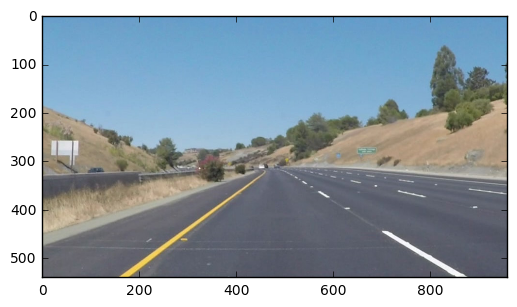

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))